In [1]:
# Import modules
import pandas as pd
import numpy as np
import bert
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tqdm import tqdm
import matplotlib.pyplot as plt

print("TensorFlow Version:",tf.__version__)
print("Hub version: ",hub.__version__)
pd.set_option('display.max_colwidth',1000)

TensorFlow Version: 2.1.0
Hub version:  0.8.0


Let's create a sample dataset containing 10,000 example, but use 20% as evaluation set.
And this time, I want to have both train and eval set to contain exactly 1% breakthrough patent. Let me try 



### Start here:

In [2]:
df = pd.read_csv('patent_abstract_5000.csv')
df

,Unnamed: 0,publication_number,application_number,text,filing_date,new_appl_nbr,appln_id,app_nbr,filing,tech_field,...,fwd_cits7_xy,breakthrough,breakthrough_xy,generality,originality,radicalness,renewal,quality_index_4,quality_index_6,quality_rank
0,1117907,EP-3412977-A1,EP-18173805-A,"A radiant module (1) comprising: a first hollow body (3) defined by a front wall (301), a rear wall (302), two sides (303), a first top end (304) having a pair of holes (308) made on the corresponding sides (303) and a bottom end (305) having a pair of holes (308) made on the corresponding sides (303); the first hollow body (3) defines a component, in use, for the passage of a heat carrier fluid, a second hollow body (2) or cover casing inside of which is entirely contained the first hollow body (3); the second hollow body (2) has a front wall (201), a rear wall (202), two sides (203), a top (204), having an air discharge section (B) and a pair of holes (4) made on the corresponding sides (203) and a bottom (210) having an air intake section (A) and a pair of holes (4) made on the corresponding sides (203), the second hollow body (2) is configured for generating an inner zone which is able to define a channel (C2) for controlled flow of the air from the intake section (A) of the bo...",20180523,EP20180173805,494709760,EP20180173805,2018,30.0,...,0,NaN,NaN,NaN,0.777778,0.916667,1.0,0.317460,0.293740,0
1,836155,EP-3062394-A1,EP-15200990-A,"An array antenna device of this disclosure includes a substrate, a strip conductor with a linear-shape, which is provided on the substrate, and a power feeder that feeds power to the strip conductor, and a plurality of loop elements, a conductor plate, and a plurality of feeding elements. The plurality of loop elements are provided on a first surface of the substrate, and are located along the strip conductor with a specified spacing from each other. Each of the plurality of loop elements has a loop-shape with a notch. The plurality of feeding elements are connected to the strip conductor, and each has a shape extending along a portion of an outer edge of corresponding one of the plurality of loop elements. The conductor plate is provided on a second surface of the substrate.",20151218,EP20150200990,447596715,EP20150200990,2015,3.0,...,0,NaN,NaN,NaN,0.777778,0.083333,3.0,0.216450,0.312182,1
2,36339,EP-2591987-A1,EP-10854435-A,A vehicle hood structure capable of improving impact absorption ability prior to a secondary impact when an impacting body impacts the hood. Front end portions 22B of beads 22 of a wave shaped section 20 are arranged in a line in hood plan view. A front wall section 28 is provided further to the hood front side than the wave shaped section 20 and is formed inclined towards the hood bottom side on progression towards the hood front and running substantially along the vehicle width direction. The wave shaped section 20 and the front wall section 28 are connected together by a ledge section 26 formed running substantially along the hood width direction.,20100708,EP20100854435,340657535,EP20100854435,2010,32.0,...,0,NaN,NaN,NaN,0.408163,0.000000,8.0,0.140097,0.243247,0
3,536885,EP-2863948-A2,EP-13807400-A,"This invention relates generally to the generation of antibodies, e.g. , monoclonal antibodies including fully human monoclonal antibodies, that recognize Jagged 1 and/or Jagged 2, to antibodies, e.g ., monoclonal antibodies including fully human antibodies that recognize Jagged 1 and/or Jagged 2, and nucleic acid molecules that encode antibodies, e.g. , nucleic acid molecules that encode monoclonal antibodies including fully human cross-reactive antibodies that recognize both Jagged 1 and Jagged 2, and to methods of making the anti- Jagged antibodies and methods of using the anti- Jagged antibodies as therapeutics, prophylactics, and diagnostics. The invention also relates generally to activatable antibodies that include a masking moiety (MM), a cleavable moiety (CM), and an antibody (AB) t

In [3]:
np.percentile(df['quality_index_4'], 50)

0.255238095238095

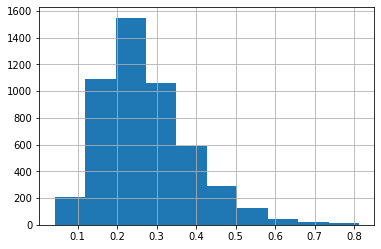

In [4]:
df['quality_index_4'].hist()

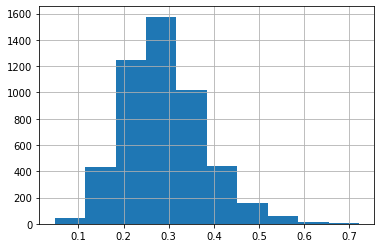

In [5]:
df['quality_index_6'].hist()

In [6]:
np.percentile(df['quality_index_6'], 50)

0.2806137569840985

In [14]:
conditions = [

    (df['quality_index_4'] < 0.3),
    (df['quality_index_4'] >= 0.3)
]

choices = ['0', '1']

In [15]:
import numpy as np
df['quality_rank'] = np.select(condlist=conditions, choicelist=choices)

In [16]:
df = df[['text','quality_rank']]

In [17]:
df.head(5)

,text,quality_rank
0,"A radiant module (1) comprising: a first hollow body (3) defined by a front wall (301), a rear wall (302), two sides (303), a first top end (304) having a pair of holes (308) made on the corresponding sides (303) and a bottom end (305) having a pair of holes (308) made on the corresponding sides (303); the first hollow body (3) defines a component, in use, for the passage of a heat carrier fluid, a second hollow body (2) or cover casing inside of which is entirely contained the first hollow body (3); the second hollow body (2) has a front wall (201), a rear wall (202), two sides (203), a top (204), having an air discharge section (B) and a pair of holes (4) made on the corresponding sides (203) and a bottom (210) having an air intake section (A) and a pair of holes (4) made on the corresponding sides (203), the second hollow body (2) is configured for generating an inner zone which is able to define a channel (C2) for controlled flow of the air from the intake section (A) of the bo...",1
1,"An array antenna device of this disclosure includes a substrate, a strip conductor with a linear-shape, which is provided on the substrate, and a power feeder that feeds power to the strip conductor, and a plurality of loop elements, a conductor plate, and a plurality of feeding elements. The plurality of loop elements are provided on a first surface of the substrate, and are located along the strip conductor with a specified spacing from each other. Each of the plurality of loop elements has a loop-shape with a notch. The plurality of feeding elements are connected to the strip conductor, and each has a shape extending along a portion of an outer edge of corresponding one of the plurality of loop elements. The conductor plate is provided on a second surface of the substrate.",0
2,A vehicle hood structure capable of improving impact absorption ability prior to a secondary impact when an impacting body impacts the hood. Front end portions 22B of beads 22 of a wave shaped section 20 are arranged in a line in hood plan view. A front wall section 28 is provided further to the hood front side than the wave shaped section 20 and is formed inclined towards the hood bottom side on progression towards the hood front and running substantially along the vehicle width direction. The wave shaped section 20 and the front wall section 28 are connected together by a ledge section 26 formed running substantially along the hood width direction.,0
3,"This invention relates generally to the generation of antibodies, e.g. , monoclonal antibodies including fully human monoclonal antibodies, that recognize Jagged 1 and/or Jagged 2, to antibodies, e.g ., monoclonal antibodies including fully human antibodies that recognize Jagged 1 and/or Jagged 2, and nucleic acid molecules that encode antibodies, e.g. , nucleic acid molecules that encode monoclonal antibodies including fully human cross-reactive antibodies that recognize both Jagged 1 and Jagged 2, and to methods of making the anti- Jagged antibodies and methods of using the anti- Jagged antibodies as therapeutics, prophylactics, and diagnostics. The invention also relates generally to activatable antibodies that include a masking moiety (MM), a cleavable moiety (CM), and an antibody (AB) that specifically bind to Jagged 1 and Jagged 2, and to methods of making and using these activatable anti- Jagged antibodies in a variety of therapeutic, diagnostic and prophylactic indications.",1
4,"Methods and implants to treat anterior cruciate ligament (ACL) injuries are disclosed. The methods involve advancing the insertion of the patellar tendon to the proximal tibia by means of a partial osteotomy and a wedge-shaped cage (30). The wedge-shaped cage is specifically designed to facilitate transfer of not only compressive loads, but also of shear loads due to pull by the patellar tendon at its insertion to the tibial tuberosity. The cage decreases the angle between the patellar tendon and the common 

In [18]:
df['text'] = df['text'].apply(str)

/home/lin_menghsien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
df.apply(lambda x: sum(x.isnull()), axis=0)

text            0
quality_rank    0
dtype: int64

In [22]:
# Functions for constructing BERT Embeddings: input_ids, input_masks, input_segments and Inputs
MAX_SEQ_LEN=500 # max sequence length

def get_masks(tokens):
    """Masks: 1 for real tokens and 0 for paddings"""
    return [1]*len(tokens) + [0] * (MAX_SEQ_LEN - len(tokens))
 
def get_segments(tokens):
    """Segments: 0 for the first sequence, 1 for the second"""  
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (MAX_SEQ_LEN - len(tokens))

def get_ids(tokens, tokenizer):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (MAX_SEQ_LEN - len(token_ids))
    return input_ids

def create_single_input(sentence, tokenizer, max_len):
    """Create an input from a sentence"""
    stokens = tokenizer.tokenize(sentence)
    stokens = stokens[:max_len]
    stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
    ids = get_ids(stokens, tokenizer)
    masks = get_masks(stokens)
    segments = get_segments(stokens)

    return ids, masks, segments
 
def convert_sentences_to_features(sentences, tokenizer):
    """Convert sentences to features: input_ids, input_masks and input_segments"""
    input_ids, input_masks, input_segments = [], [], []
 
    for sentence in tqdm(sentences,position=0, leave=True):
      ids,masks,segments=create_single_input(sentence,tokenizer,MAX_SEQ_LEN-2)
      assert len(ids) == MAX_SEQ_LEN
      assert len(masks) == MAX_SEQ_LEN
      assert len(segments) == MAX_SEQ_LEN
      input_ids.append(ids)
      input_masks.append(masks)
      input_segments.append(segments)

    return [np.asarray(input_ids, dtype=np.int32), 
          np.asarray(input_masks, dtype=np.int32), 
          np.asarray(input_segments, dtype=np.int32)]

def create_tonkenizer(bert_layer):
    """Instantiate Tokenizer with vocab"""
    vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()
    do_lower_case=bert_layer.resolved_object.do_lower_case.numpy() 
    tokenizer=bert.bert_tokenization.FullTokenizer(vocab_file,do_lower_case)
    return tokenizer

In [23]:
def bert_model(callable_object):
    # Load the pre-trained BERT base model
    bert_layer = hub.KerasLayer(handle=callable_object, trainable=True)  
   
    # BERT layer three inputs: ids, masks and segments
    input_ids = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_ids")           
    input_masks = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_masks")       
    input_segments = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="segment_ids")
    
    inputs = [input_ids, input_masks, input_segments] # BERT inputs
    pooled_output, sequence_output = bert_layer(inputs) # BERT outputs
    
    # Add a hidden layer
    x = Dense(units=768, activation='relu')(pooled_output)
    x = Dropout(0.1)(x)
 
    # Add output layer
    outputs = Dense(1, activation="sigmoid")(x)

    # Construct a new model
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = bert_model("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 500)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 500)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_ids[0][0]                  
                                                                 input_masks[0][0]            

In [24]:
df['quality_rank'] = df['quality_rank'].astype(int)

/home/lin_menghsien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
# Create examples for training and testing
df = df.sample(frac=1) # Shuffle the dataset
tokenizer = create_tonkenizer(model.layers[3])
X_train = convert_sentences_to_features(df['text'][:4000], tokenizer)
X_test = convert_sentences_to_features(df['text'][4000:], tokenizer)

# this one_hot_encoded seems like for multi-class
#one_hot_encoded = to_categorical(df['quality_rank'].values)
#y_train = one_hot_encoded[:4000]
#y_test =  one_hot_encoded[4000:]

# for binary classification, since in the loss function I use binary_crossentropy, looks like prefer this single array
y_train = df['quality_rank'][:4000]
y_test =  df['quality_rank'][4000:]




100%|██████████| 1000/1000 [00:02<00:00, 496.11it/s]


In [28]:
y_train.value_counts()

0    2650
1    1350
Name: quality_rank, dtype: int64

In [30]:
y_test.value_counts()

0    659
1    341
Name: quality_rank, dtype: int64

In [26]:
# Train the model
BATCH_SIZE = 10
EPOCHS = 1

# Use Adam optimizer to minimize the categorical_crossentropy loss
opt = Adam(learning_rate=2e-5)
model.compile(optimizer=opt, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Fit the data to the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose = 1)

# Save the trained model
model.save('bert_model_quality_index_4.h5')
model.save_weights('bert_weights_quality_index_4.h5')

Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 8195s 2s/sample - loss: 0.6444 - accuracy: 0.6575 - val_loss: 0.6380 - val_accuracy: 0.6590


# Load the pretrained nlp_model
from tensorflow.keras.models import load_model

new_model = load_model('bert_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})

In [22]:
# Predict on test dataset
from sklearn.metrics import classification_report
pred_test = np.argmax(model.predict(X_test), axis=1)

In [23]:
print(classification_report(np.argmax(y_test,axis=1), pred_test))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1815
           1       0.00      0.00      0.00       185

    accuracy                           0.91      2000
   macro avg       0.45      0.50      0.48      2000
weighted avg       0.82      0.91      0.86      2000



/home/lin_menghsien/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
np.unique(pred_test, return_counts = True)

(array([0]), array([2000]))

In [25]:
# Predict on train dataset
from sklearn.metrics import classification_report
pred_train = np.argmax(model.predict(X_train), axis=1)

In [26]:
print(classification_report(np.argmax(y_train,axis=1), pred_train))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      7185
           1       0.00      0.00      0.00       815

    accuracy                           0.90      8000
   macro avg       0.45      0.50      0.47      8000
weighted avg       0.81      0.90      0.85      8000



In [24]:
model.save_weights('bert_weights.h5')

In [30]:
np.unique(pred_train, return_counts = True)

(array([0]), array([8000]))